In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold


In [37]:
original_data = pd.read_csv('car-data/car_price_prediction.csv')

original_data.head(10)

'''
Data Cleaning:
Levy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column
Mileage - Remove km and make it numerical 
Engine Volume - Is not numeric and contains strings 'Turbo'
Doors has following values and must be changed to 2, 4, or 6 (ordinal scale)

04-May    18332
02-Mar      777
>5          128
'''

"\nData Cleaning:\nLevy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column\nMileage - Remove km and make it numerical \nEngine Volume - Is not numeric and contains strings 'Turbo'\nDoors has following values and must be changed to 2, 4, or 6 (ordinal scale)\n\n04-May    18332\n02-Mar      777\n>5          128\n"

In [38]:
original_data.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [39]:
original_data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [76]:
from data_utils import *

processed_data = preprocess(original_data) # Use full dataset for data analysis
OHE_processed_data = OHE_data(processed_data)
X_train, y_train, X_test, y_test = split_data(OHE_processed_data) # Use train/test split data for modeling


In [83]:
processed_data.describe()

,Price,Levy,Engine_volume,Mileage,Cylinders,Doors,Airbags,Age
count,16309.000000,16309.000000,16309.000000,1.630900e+04,16309.000000,16309.000000,16309.000000,16309.000000
mean,13261.857502,898.356754,2.286394,1.646308e+06,4.544178,3.931572,6.548961,14.170274
std,11056.534201,398.286413,0.868106,4.980061e+07,1.140633,0.363569,4.344287,5.585765
min,1.000000,87.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000,5.000000
25%,3920.000000,707.000000,1.800000,7.480000e+04,4.000000,4.000000,4.000000,11.000000
50%,11447.000000,906.838128,2.000000,1.299310e+05,4.000000,4.000000,5.000000,13.000000
75%,19281.000000,915.000000,2.500000,1.900000e+05,4.000000,4.000000,12.000000,16.000000
max,45872.000000,11714.000000,20.000000,2.147484e+09,16.000000,4.000000,16.000000,86.000000


In [41]:
processed_data.head()

,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


In [42]:
X_train.head()

,Levy,Engine_volume,Mileage,Cylinders,Doors,Airbags,Age,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,Manufacturer_AUDI,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
11736,308.000000,1.5,31040,4.0,4,4,10,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18347,765.000000,2.0,581040,4.0,4,4,10,False,False,False,...,False,False,True,False,False,False,False,False,False,False
14924,906.838128,1.5,222061,4.0,4,4,17,False,False,False,...,False,False,False,False,False,True,False,False,False,False
18956,382.000000,1.5,81440,4.0,4,0,8,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11616,394.000000,2.5,109798,4.0,4,12,11,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [43]:
''' Data is cleaned and prepped'''

' Data is cleaned and prepped'

**EXAMINING NUMERICAL FEATURES**

In [44]:
'''
Numerical Predictor Columns:
Levy
Age
Engine volume
Mileage
Cylinders
Doors
Airbags
'''

'\nNumerical Predictor Columns:\nLevy\nAge\nEngine volume\nMileage\nCylinders\nDoors\nAirbags\n'

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000 -0.120360      -0.016306 -0.166936  -0.110859   
Levy          -0.120360  1.000000       0.489328  0.063320   0.504233   
Engine_volume -0.016306  0.489328       1.000000  0.164322   0.686529   
Mileage       -0.166936  0.063320       0.164322  1.000000   0.167381   
Cylinders     -0.110859  0.504233       0.686529  0.167381   1.000000   
Doors          0.036624 -0.075552      -0.001725  0.005335  -0.047848   
Airbags       -0.099722  0.121401       0.278949 -0.010684   0.217503   
Age           -0.221744  0.241829       0.024217  0.304246   0.177922   

                  Doors   Airbags       Age  
Price          0.036624 -0.099722 -0.221744  
Levy          -0.075552  0.121401  0.241829  
Engine_volume -0.001725  0.278949  0.024217  
Mileage        0.005335 -0.010684  0.304246  
Cylinders     -0.047848  0.217503  0.177922  
Doors          1.000000  0.035842 -0.136330  
Airbags        0.035

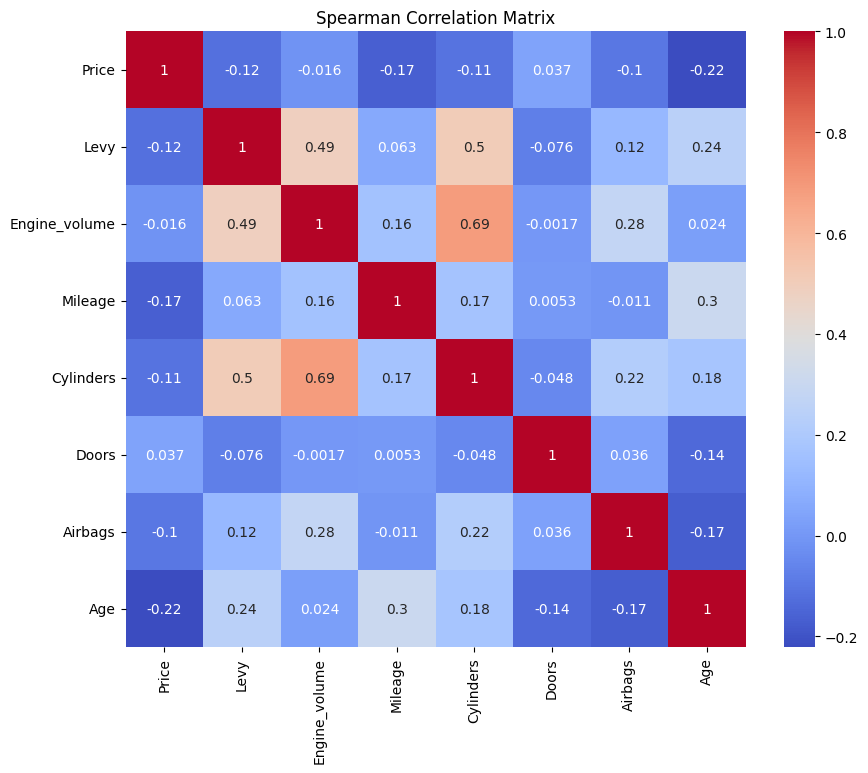

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000 -0.063645      -0.014931 -0.019637  -0.066208   
Levy          -0.063645  1.000000       0.544593  0.002640   0.487920   
Engine_volume -0.014931  0.544593       1.000000 -0.006930   0.791084   
Mileage       -0.019637  0.002640      -0.006930  1.000000   0.000009   
Cylinders     -0.066208  0.487920       0.791084  0.000009   1.000000   
Doors          0.041651 -0.040971      -0.018736  0.004315  -0.042397   
Airbags       -0.109589  0.098824       0.250271 -0.007371   0.180825   
Age           -0.263187  0.123111       0.031423  0.068909   0.120736   

                  Doors   Airbags       Age  
Price          0.041651 -0.109589 -0.263187  
Levy          -0.040971  0.098824  0.123111  
Engine_volume -0.018736  0.250271  0.031423  
Mileage        0.004315 -0.007371  0.068909  
Cylinders     -0.042397  0.180825  0.120736  
Doors          1.000000  0.034354 -0.186287  
Airbags        0.034

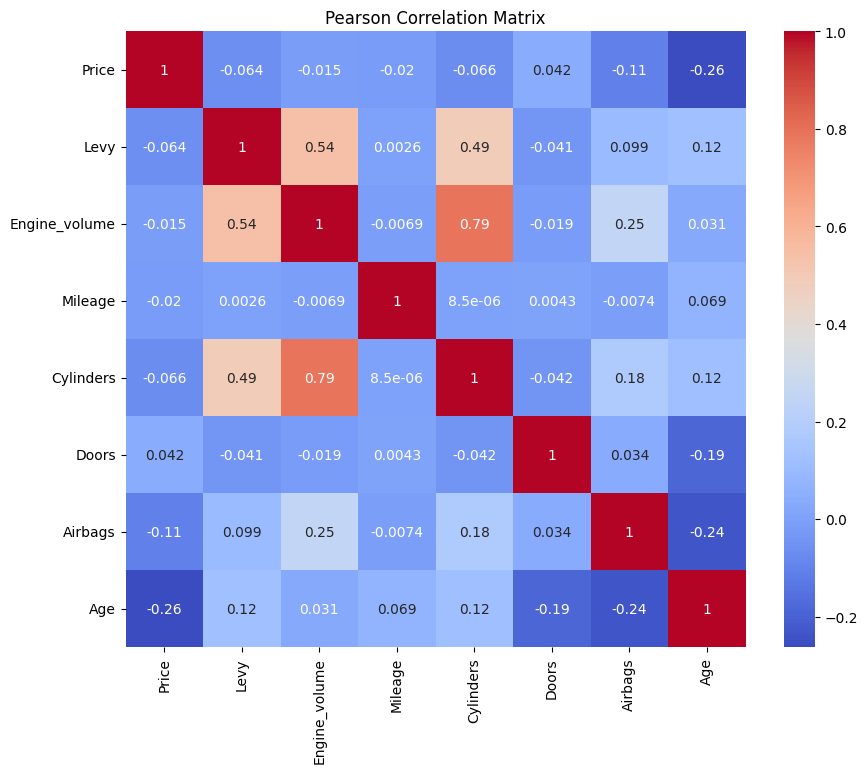

In [45]:
numerical_columns = processed_data.select_dtypes(include=['float64', 'int64'])
numerical_columns.head()

# Compute the SPEARMAN correlation matrix
corr_matrix_spearman = numerical_columns.corr(method='spearman')
print(corr_matrix_spearman)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

# Compute the PEARSON correlation matrix
corr_matrix_pearson = numerical_columns.corr(method='pearson')
print(corr_matrix_pearson)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Matrix")
plt.show()

Spearman Correlation Matrix: (Focus on monotonic relationships - can be nonlinear)
- Price has a weak negative correlation with mileage (-0.20) and age (-0.29)
- Price has ittle to no correlation with any of the other predictors
- Cylinders and engine volume have a moderately strong, positive correlation of 0.69
- Engine volume and levy have a moderatem positive correlation of 0.5 
- Cylinder and levy have a moderate positive correlation of 0.49

Pearson Correlation Matrix: (Measures linear relationships)
- Cylinders and engine volume have a strong, positive correlation of 0.8
- Levy and cylinders and levy and engine volume have similar moderate, positive correations of 0.46 and 0.55 respectivly  


In [46]:
# OLS for predicting price

formula = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags + C(Manufacturer) + C(Model) + C(Category) + C(Leather_interior) + C(Fuel_type) + C(Gear_box_type) + C(Drive_wheels) + C(Wheel) + C(Color)'

OLS_model = smf.ols(formula=formula, data=processed_data).fit()
print(OLS_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     11.37
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:34:00   Log-Likelihood:            -1.7036e+05
No. Observations:               16392   AIC:                         3.433e+05
Df Residuals:                   15113   BIC:                         3.531e+05
Df Model:                        1278                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [47]:
# ANOVA
anova_table = sm.stats.anova_lm(OLS_model, typ=2)
print(anova_table)

                           sum_sq       df            F         PR(>F)
C(Manufacturer)      2.162112e+10     59.0     5.422594   5.049502e-37
C(Model)             3.505538e+11   1225.0     4.234475   0.000000e+00
C(Category)          7.127781e+09     10.0    10.547155   5.092698e-18
C(Leather_interior)  1.259906e+10      1.0   186.431365   3.401275e-42
C(Fuel_type)         3.002540e+10      6.0    74.048882   1.927648e-91
C(Gear_box_type)     7.019422e+10      3.0   346.227132  1.829242e-217
C(Drive_wheels)      1.371662e+09      2.0    10.148410   3.940566e-05
C(Wheel)             7.288800e+09      1.0   107.854185   3.516065e-25
C(Color)             4.065378e+09     15.0     4.010428   2.460136e-07
Levy                 7.619969e+08      1.0    11.275458   7.873235e-04
Age                  8.086651e+10      1.0  1196.601954  2.062096e-252
Engine_volume        1.708583e+08      1.0     2.528233   1.118463e-01
Mileage              1.638814e+05      1.0     0.002425   9.607253e-01
Cylind

- Having this many predictors is clearly causing issues in predictive power of model.
- Must conduct feature selection to check for multi-colienarity and use Variance Inflation Factor (VIF) to see which variables are redundant
- VIF > 5 means there is likely colinearly in in the feature with other features in model

In [48]:
''' It seems the numerical features all have VIF values under 5. Engine volume and cylinders have the highest VIF values, however, they are not so high that it warrants feature removal'''

formula_numerical = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags'
y, X = dmatrices(formula_numerical, data=processed_data, return_type='dataframe')
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

         Feature         VIF
0      Intercept  141.657079
3  Engine_volume    3.057602
5      Cylinders    2.765015
1           Levy    1.458021
2            Age    1.147828
7        Airbags    1.139934
6          Doors    1.036923
4        Mileage    1.005310


In [49]:
processed_data.head()

,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


**FULL CORRELATION MATRIX**

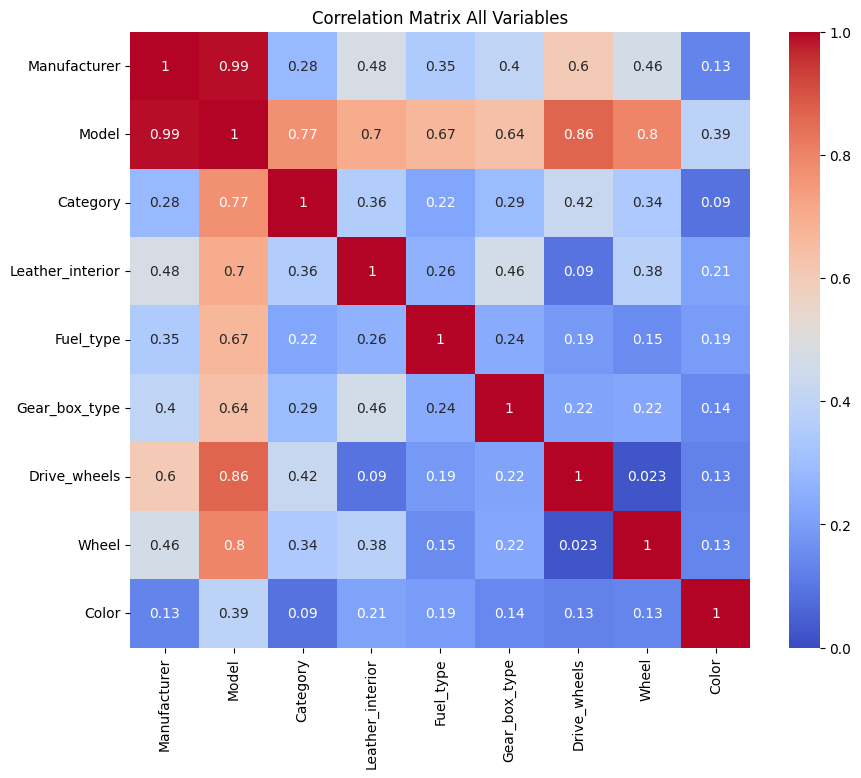

In [63]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # not enough variability
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

categorical_cols = [
    'Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
    'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color'
]


cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for feature_1 in categorical_cols:
    for feature_2 in categorical_cols:
        if feature_1 == feature_2:
            cramers_results.loc[feature_1, feature_2] = 1.0
        else:
            try:
                subset = processed_data[[feature_1, feature_2]].dropna()
                value = cramers_v(subset[feature_1], subset[feature_2])
                cramers_results.loc[feature_1, feature_2] = value
            except Exception as e:
                print(f"Error between {feature_1} and {feature_2}: {e}")
                cramers_results.loc[feature_1, feature_2] = None

cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Matrix All Variables")
plt.show()

- Model and manufacturer have almost perfect correlation of 0.99
- Model had a very high correlation with many of the other predictors such as wheel, Drive wheels, gear box type, leather interior, category, and manufacturer
- Should remove Model feature since there is too much correlation between this and other variables
- Mileage also shows very high correlation with all other variables

**PCA**

                                 PC1       PC2
Engine_volume               0.352953  0.142276
Cylinders                   0.309073  0.193790
Leather_interior_Yes        0.290650 -0.239987
Drive_wheels_4x4            0.246599  0.165342
Category_Jeep               0.211951  0.010063
Wheel_Left wheel            0.210717 -0.159269
Levy                        0.177004  0.186912
Manufacturer_MERCEDES-BENZ  0.166413  0.147604
Manufacturer_LEXUS          0.136524  0.020260
Gear_box_type_Automatic     0.122994 -0.282395
Airbags                     0.119027 -0.025442
Fuel_type_Diesel            0.115034 -0.087682
Color_Black                 0.112511  0.034039
Manufacturer_BMW            0.105386  0.127658
Drive_wheels_Rear           0.096194  0.226347
Manufacturer_AUDI           0.047257  0.018453
Manufacturer_PORSCHE        0.035020  0.013750
Manufacturer_JEEP           0.030960  0.009284
Manufacturer_INFINITI       0.030799  0.023777
Manufacturer_SSANGYONG      0.025304 -0.074169


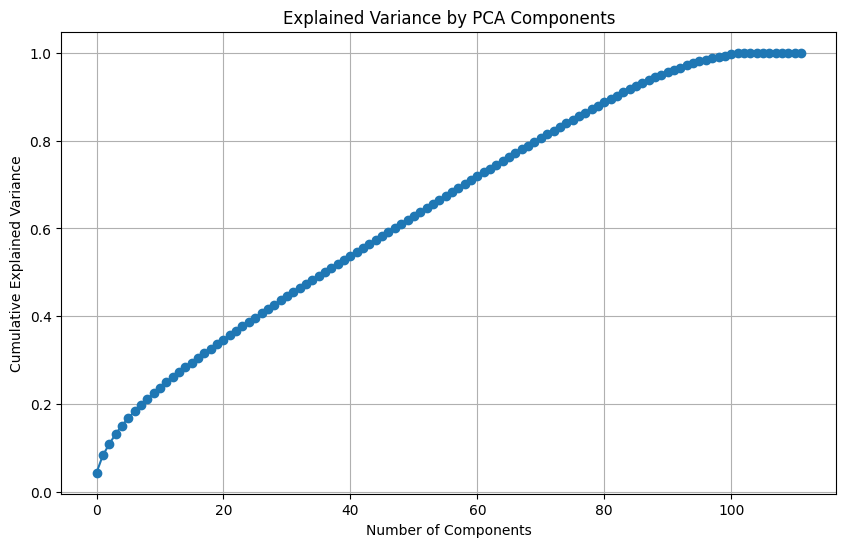

In [51]:
# Standardize features using training sample
X = X_train

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_


# Create a loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(X.columns))],
    index=X.columns
)

# View top contributors to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(20))


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [52]:
# OLS regression with PCA components (PCR)

# Find the top PC's that explain 95% of the variance
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca_95 = pca.fit_transform(X_scaled)

print(f"Number of components kept: {X_pca_95.shape[1]}")  # should be more than 1

# Run OLS on all of them
X_pca_95_const = sm.add_constant(X_pca_95)
ols_model = sm.OLS(y_train, X_pca_95_const).fit()
print(ols_model.summary())

Number of components kept: 91
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     64.72
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:34:16   Log-Likelihood:            -1.3827e+05
No. Observations:               13113   AIC:                         2.767e+05
Df Residuals:                   13021   BIC:                         2.774e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.334e+04 

In [67]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score

# 1. Build a pipeline: Scaling -> PCA -> Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

# 2. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=100)

# 4. Cross-validation scores (pipeline automatically fits scaler/PCA inside CV folds)
rmse_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average CV R²: {np.mean(r2_scores):.4f}")

# 6. Train final model
pipeline.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_test = pipeline.predict(X_test)

print(f"🧪 Test Set R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"🧪 Test Set RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")


🔹 Average CV RMSE: 9272.84
🔹 Average CV R²: 0.2987
🧪 Test Set R²: 0.3130
🧪 Test Set RMSE: 9095.18


In [66]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score


# 1. Set up model
model = LinearRegression()

# 2. Define custom scorers
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
r2_scorer = make_scorer(r2_score)

# 3. Set up Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=100)

# 4. Run Cross-Validation
rmse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=r2_scorer)

# 5. Results for CV
print(f"🔹 Average CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average CV R²: {np.mean(r2_scores):.4f}")

# 6. Fit final model on all training data
model.fit(X_train, y_train)

# 7. Transform and evaluate on TEST set
y_pred_test = model.predict(X_test)

print(f"🧪 Test Set R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"🧪 Test Set RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")


🔹 Average CV RMSE: 8950.59
🔹 Average CV R²: 0.3466
🧪 Test Set R²: 0.3415
🧪 Test Set RMSE: 8904.16


**RIDGE REGRESSION**

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score

# 1. Set up a Pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('ridge', Ridge(alpha=2))
])

# 3. Set up Cross-Validation

# Bin prices into categories
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')

# Create Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                      
# 4. Cross-validation scores
rmse_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average Stratified CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 6. Train on all training data
ridge_pipeline.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_ridge = ridge_pipeline.predict(X_test)
print("🧪 Ridge Test R²:", r2_score(y_test, y_pred_ridge))
print("🧪 Ridge Test RMSE:", root_mean_squared_error(y_test, y_pred_ridge))


🔹 Average Stratified CV RMSE: 9274.41
🔹 Average Stratified CV R²: 0.2986
🧪 Ridge Test R²: 0.31296236153696333
🧪 Ridge Test RMSE: 9095.17475275772


In [72]:
from sklearn.linear_model import Ridge

#  1. Set up Ridge Regression model
ridge = Ridge(alpha=2)

# 3. Set up Cross-Validation

# Bin prices into categories
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')

# Create Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                      
# 4. Cross-validation scores
rmse_scores = cross_val_score(ridge, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(ridge, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average Stratified CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 7. Train final Ridge model on all training data
ridge.fit(X_train, y_train)

# 8. Evaluate on test set
y_pred_ridge = ridge.predict(X_test)
print("🧪 Ridge Test R²:", r2_score(y_test, y_pred_ridge))
print("🧪 Ridge Test RMSE:", root_mean_squared_error(y_test, y_pred_ridge))

c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.3643e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.81894e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.00243e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.95119e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.50703e-20):

🔹 Average Stratified CV RMSE: 8947.14
🔹 Average Stratified CV R²: 0.3473
🧪 Ridge Test R²: 0.34235403526473884
🧪 Ridge Test RMSE: 8898.501188209406


c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.95119e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.50703e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.00409e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


**LASSO REGRESSION**

In [73]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score

# 1. Define Pipeline: Scaling + PCA + Lasso
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('lasso', Lasso(alpha=0.5, max_iter=10000, random_state=42))
])

# 2. Scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Cross-Validation Scores
rmse_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=kf, scoring=r2_scorer)

# 5. Results
print(f"🔹 Average Lasso CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Lasso CV R²: {np.mean(r2_scores):.4f}")

# 6. Fit final model on all training data
lasso_pipeline.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_test = lasso_pipeline.predict(X_test)
print("🧪 Lasso Test R²:", r2_score(y_test, y_pred_test))
print("🧪 Lasso Test RMSE:", root_mean_squared_error(y_test, y_pred_test))


🔹 Average Lasso CV RMSE: 9271.69
🔹 Average Lasso CV R²: 0.2989
🧪 Lasso Test R²: 0.31298404347707653
🧪 Lasso Test RMSE: 9095.031236173518


In [75]:
from sklearn.linear_model import Lasso

# 1. Define Pipeline: Scaling + Lasso
lasso = Lasso(alpha=0.5, max_iter=10000, random_state=42)

# 2. Scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Cross-Validation Scores
rmse_scores = cross_val_score(lasso, X_train, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(lasso, X_train, y_train, cv=kf, scoring=r2_scorer)

# 5. Results
print(f"🔹 Average Lasso CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Lasso CV R²: {np.mean(r2_scores):.4f}")

# 6. Train final model on all training data
lasso.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_test = pipeline.predict(X_test)
print("🧪 Lasso Test R²:", r2_score(y_test, y_pred_test))
print("🧪 Lasso Test RMSE:", root_mean_squared_error(y_test, y_pred_test))


🔹 Average Lasso CV RMSE: 8950.26
🔹 Average Lasso CV R²: 0.3466
🧪 Lasso Test R²: 0.31296170489793795
🧪 Lasso Test RMSE: 9095.179099131865


**LINEAR MODEL OVERVIEW**

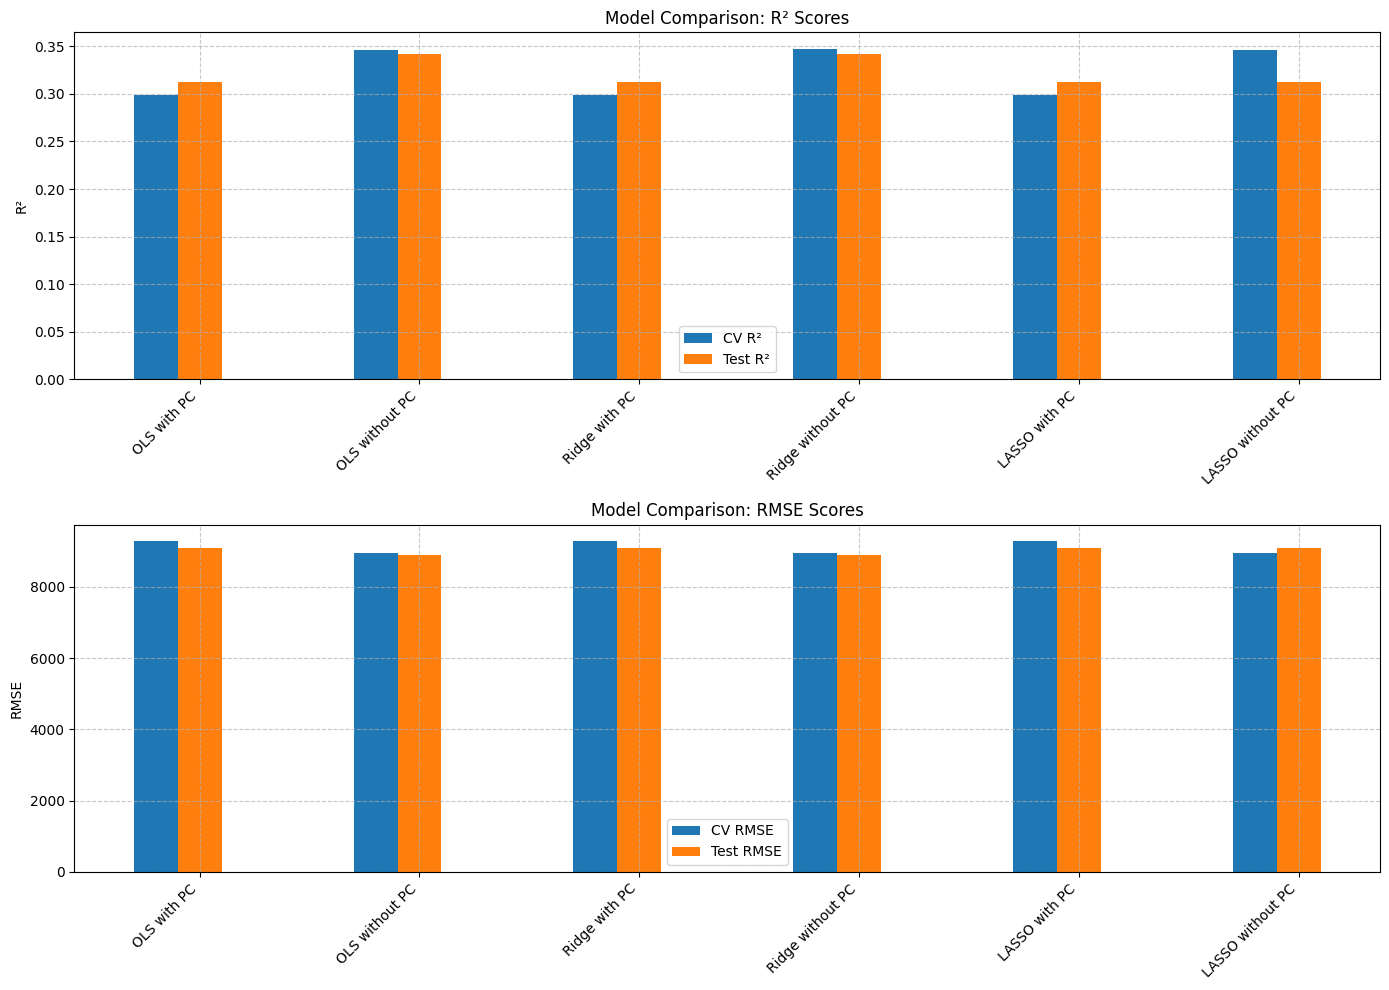

In [79]:
import matplotlib.pyplot as plt

# Data
models = [
    'OLS with PC', 'OLS without PC',
    'Ridge with PC', 'Ridge without PC',
    'LASSO with PC', 'LASSO without PC'
]

cv_rmse = [9272.84, 8950.59, 9274.41, 8947.14, 9271.69, 8950.26]
cv_r2 = [0.2987, 0.3466, 0.2986, 0.3473, 0.2989, 0.3466]
test_r2 = [0.3130, 0.3415, 0.3130, 0.3424, 0.3130, 0.3130]
test_rmse = [9095.18, 8904.16, 9095.17, 8898.50, 9095.03, 9095.18]

# Bar Width
bar_width = 0.2
x = np.arange(len(models))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# First subplot for R²
axs[0].bar(x - bar_width, cv_r2, width=bar_width, label='CV R²')
axs[0].bar(x, test_r2, width=bar_width, label='Test R²')
axs[0].set_ylabel('R²')
axs[0].set_title('Model Comparison: R² Scores')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45, ha='right')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Second subplot for RMSE
axs[1].bar(x - bar_width, cv_rmse, width=bar_width, label='CV RMSE')
axs[1].bar(x, test_rmse, width=bar_width, label='Test RMSE')
axs[1].set_ylabel('RMSE')
axs[1].set_title('Model Comparison: RMSE Scores')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45, ha='right')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



**NONLINEAR MODELS**

**DECISION TREES**

In [ ]:
# Decision Tree Regressor (Hyperparameter Tuning)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score


# 1. Base Decision Tree model
tree = DecisionTreeRegressor(random_state=42)

# 2. Define hyperparameter grid
param_grid = {
    'max_depth': [10, 30, 50, 100, 300, None],   # Allow very deep trees or unlimited
    'min_samples_split': [2, 5, 10, 20],         # Minimum samples needed to split
    'min_samples_leaf': [1, 2, 5, 10],           # Minimum samples required at leaf
    'max_features': [None, 'sqrt', 'log2']       # Feature selection at each split
}

# 3. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # Negative for GridSearchCV
r2_scorer = make_scorer(r2_score)

# 4. Set up Stratified Cross-Validation
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=rmse_scorer,    # Tune using RMSE
    cv=skf.split(X_train, price_bins),
    n_jobs=-1,
    verbose=2
)

# 6. Run grid search
grid_search.fit(X_train, y_train)

# 7. Best model
print("✅ Best Parameters:", grid_search.best_params_)
print(f"✅ Best CV RMSE: {abs(grid_search.best_score_):.2f}")

# 8. Train final model with best hyperparameters
best_tree = grid_search.best_estimator_

# 9. Cross-validation scores for best model
rmse_scores = cross_val_score(best_tree, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(best_tree, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

print(f"🔹 Average Stratified CV RMSE: {np.abs(np.mean(rmse_scores)):.2f}")
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 10. Train on full training data
best_tree.fit(X_train, y_train)

# 11. Evaluate on test set
y_pred_tree = best_tree.predict(X_test)
print("🧪 Decision Tree Test R²:", r2_score(y_test, y_pred_tree))
print("🧪 Decision Tree Test RMSE:", root_mean_squared_error(y_test, y_pred_tree))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


✅ Best Parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
✅ Best CV RMSE: 6456.14
🔹 Average Stratified CV RMSE: 6456.14
🔹 Average Stratified CV R²: 0.6601
🧪 Decision Tree Test R²: 0.6787032617153336
🧪 Decision Tree Test RMSE: 6218.23866330141


**BAGGING**

In [78]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

# 1. Set up base Decision Tree
base_model = DecisionTreeRegressor(random_state=42)

# 2. Bagging Regressor
bagging = BaggingRegressor(
    estimator=base_model,
    random_state=42,
    n_jobs=-1
)

# 3. Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'estimator__max_depth': [10, 50, 100]
}

# 4. Scorers
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # negative RMSE for GridSearchCV
r2_scorer = make_scorer(r2_score)

# 5. Stratified Cross-Validation
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. GridSearchCV
grid_search = GridSearchCV(
    bagging,
    param_grid,
    scoring=rmse_scorer,  # Focus tuning on RMSE
    cv=skf.split(X_train, price_bins),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print(f"✅ Best CV RMSE: {abs(grid_search.best_score_):.2f}")

# 7. Train final model
best_bagging_model = grid_search.best_estimator_
best_bagging_model.fit(X_train, y_train)

# 8. Test evaluation
y_pred_bagging = best_bagging_model.predict(X_test)
print("🧪 Bagging Test R²:", r2_score(y_test, y_pred_bagging))
print("🧪 Bagging Test RMSE:", root_mean_squared_error(y_test, y_pred_bagging))

# 9. Full Stratified Cross-Validation with Best Model
# (important: use cross_val_score with skf.split to keep stratification)
rmse_scores = cross_val_score(
    best_bagging_model, X_train, y_train,
    scoring=rmse_scorer,
    cv=skf.split(X_train, price_bins),
    n_jobs=-1
)
r2_scores = cross_val_score(
    best_bagging_model, X_train, y_train,
    scoring=r2_scorer,
    cv=skf.split(X_train, price_bins),
    n_jobs=-1
)

print(f"🔹 Average Stratified CV RMSE: {np.abs(np.mean(rmse_scores)):.2f}")  # Take abs because RMSE is negative
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best Parameters: {'estimator__max_depth': 50, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 500}
✅ Best CV RMSE: 5268.19
🧪 Bagging Test R²: 0.7800951440308413
🧪 Bagging Test RMSE: 5144.363381688779
🔹 Average Stratified CV RMSE: 5268.19
🔹 Average Stratified CV R²: 0.7737


**RANDOM FOREST**

In [59]:
from sklearn.ensemble import RandomForestRegressor

# 1. Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,  # number of trees
    max_depth=100,    # you can set max_depth if you want to limit complexity
    random_state=42,
    n_jobs=-1          # use all CPU cores
)

# 2. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Set up Cross-Validation
# Bin prices into categories
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')

# Create Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                  

# 4. Cross-validation scores
rmse_scores = cross_val_score(rf_model, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(rf_model, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average Stratified CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 6. Train final Random Forest model on full training set
rf_model.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_rf = rf_model.predict(X_test)
print("🧪 Random Forest Test R²:", r2_score(y_test, y_pred_rf))
print("🧪 Random Forest Test RMSE:", root_mean_squared_error(y_test, y_pred_rf))


🔹 Average Stratified CV RMSE: 5332.74
🔹 Average Stratified CV R²: 0.7680
🧪 Random Forest Test R²: 0.7854790517054044
🧪 Random Forest Test RMSE: 5082.245464784251


Hyperparameter tuning random forest:

In [60]:
from sklearn.model_selection import GridSearchCV

# 1. Define model (no parameters yet, we'll tune them)
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [20, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# 3. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # Needs to be negative for GridSearchCV
r2_scorer = make_scorer(r2_score)

# 4. Set up Stratified K-Fold
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=rmse_scorer,  # Tune using RMSE
    cv=skf.split(X_train, price_bins),
    verbose=2,
    n_jobs=-1
)

# 6. Run grid search
grid_search.fit(X_train, y_train)

print(f"✅ Best hyperparameters: {grid_search.best_params_}")

# 7. Train best model
best_rf = grid_search.best_estimator_

# 8. Cross-validation scores with best model
rmse_scores = cross_val_score(best_rf, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(best_rf, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

print(f"🔹 Average Stratified CV RMSE: {np.abs(np.mean(rmse_scores)):.2f}")  # Take abs because RMSE was negative
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 9. Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
print("🧪 Random Forest Test R²:", r2_score(y_test, y_pred_rf))
print("🧪 Random Forest Test RMSE:", root_mean_squared_error(y_test, y_pred_rf))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best hyperparameters: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
🔹 Average Stratified CV RMSE: 5360.57
🔹 Average Stratified CV R²: 0.7656
🧪 Random Forest Test R²: 0.7848503309663549
🧪 Random Forest Test RMSE: 5089.687570924588


**GRADIENT BOOSTING**

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Set up Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.7, 0.85, 1.0],       # Try some subsampling (stochastic gradient boosting)
    'max_features': ['sqrt', 'log2', None]  # Feature sampling
}

# 3. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # GridSearch needs negative
r2_scorer = make_scorer(r2_score)

# 4. Set up Stratified K-Fold
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Grid Search
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,  # Focus tuning on RMSE
    cv=skf.split(X_train, price_bins),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 6. Best hyperparameters and results
print("✅ Best Hyperparameters:", grid_search.best_params_)
print(f"✅ Best CV RMSE: {abs(grid_search.best_score_):.2f}")

# 7. Retrain final model
best_gb_model = grid_search.best_estimator_

# 8. Cross-validation scores
rmse_scores = cross_val_score(best_gb_model, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(best_gb_model, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

print(f"🔹 Average Stratified CV RMSE: {np.abs(np.mean(rmse_scores)):.2f}")  # Take abs because RMSE was negative
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 9. Test set evaluation
best_gb_model.fit(X_train, y_train)
y_pred_gb = best_gb_model.predict(X_test)

print("🧪 Gradient Boosting Test R²:", r2_score(y_test, y_pred_gb))
print("🧪 Gradient Boosting Test RMSE:", root_mean_squared_error(y_test, y_pred_gb))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


✅ Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 10, 'max_features': None, 'n_estimators': 300, 'subsample': 0.7}
✅ Best CV RMSE: 5209.27
🔹 Average Stratified CV RMSE: 5209.27
🔹 Average Stratified CV R²: 0.7786
🧪 Gradient Boosting Test R²: 0.784762021693598
🧪 Gradient Boosting Test RMSE: 5089.483145281786


**XGBOOST**

In [77]:
import xgboost as xgb


# 1. Define model (no parameters yet, we'll tune them)
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_lambda': [0, 1, 5],    # L2 regularization
    'reg_alpha': [0, 0.5, 1],   # L1 regularization
}

# 3. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# 4. Set up Stratified K-Fold
price_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')  # Create 10 bins for stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=skf.split(X_train, price_bins),
    verbose=2,
    n_jobs=-1
)

# 6. Run grid search
grid_search.fit(X_train, y_train)

print(f"✅ Best hyperparameters: {grid_search.best_params_}")

# 7. Train best model
best_xgb = grid_search.best_estimator_

# 8. Cross-validation scores with best model
rmse_scores = cross_val_score(best_xgb, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=rmse_scorer)
r2_scores = cross_val_score(best_xgb, X_train, y_train, cv=skf.split(X_train, price_bins), scoring=r2_scorer)

print(f"🔹 Average Stratified CV RMSE: {np.abs(np.mean(rmse_scores)):.2f}")
print(f"🔹 Average Stratified CV R²: {np.mean(r2_scores):.4f}")

# 9. Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
print("🧪 XGBoost Test R²:", r2_score(y_test, y_pred_xgb))
print("🧪 XGBoost Test RMSE:", root_mean_squared_error(y_test, y_pred_xgb))


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
✅ Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.9}
🔹 Average Stratified CV RMSE: 5155.40
🔹 Average Stratified CV R²: 0.7832
🧪 XGBoost Test R²: 0.7917989492416382
🧪 XGBoost Test RMSE: 5005.5948051546475


**GENERALIZED ADDITIVE MODEL**

In [62]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold

# 1. Build a pipeline that applies splines and then Ridge Regression
spline_model = make_pipeline(
    SplineTransformer(degree=3, n_knots=5, include_bias=False),
    Ridge(alpha=1.0)
)

# 2. Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(spline_model, X_train, y_train, cv=kf, scoring='r2')

print(f"🔹 Average GAM-like Ridge CV R²: {np.mean(r2_scores):.4f}")

# 3. Fit on full training set
spline_model.fit(X_train, y_train)

# 4. Evaluate on test set
y_pred = spline_model.predict(X_test)
print("🧪 GAM-like Ridge Test R²:", r2_score(y_test, y_pred))
print("🧪 GAM-like Ridge Test RMSE:", root_mean_squared_error(y_test, y_pred))


🔹 Average GAM-like Ridge CV R²: 0.4404
🧪 GAM-like Ridge Test R²: 0.4499215716490831
🧪 GAM-like Ridge Test RMSE: 8138.288661470039
